In this practical session, you will implement different strategies to build a recommender system.

# Dataset



We will be utilizing 'The Movie Dataset' hosted on Kaggle, featuring comprehensive metadata for 45,000 movies listed in the Full MovieLens Dataset (accessible here: [Full MovieLens Dataset](https://grouplens.org/datasets/movielens/)). The dataset encompasses films released up until July 2017 and includes a variety of data points such as cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, as well as TMDB vote counts and vote averages.

Additionally, this dataset encompasses 26 million ratings from 270,000 users across all 45,000 movies. These ratings, ranging from 1 to 5, are sourced directly from the official GroupLens website.

To access this dataset, a [Kaggle](https://www.kaggle.com/) account is required. After logging into Kaggle, navigate to your account settings and scroll to the API section to generate a new API token. This token will facilitate the direct download of the dataset via the Kaggle library in your notebook.

![Instructions for generating a Kaggle API token](https://drive.google.com/uc?export=view&id=1YcSTHD_FGrwDKaaLk6T9Gsdte8TKuPCt)

Now, you can proceed to install the Kaggle library in your notebook, which allows for the dataset to be downloaded directly.


In [3]:
!pip install kaggle

Run the next cell to upload your token.

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


We will begin by analyzing the metadata dataset, which includes comprehensive information about the movies.  
This dataset encompasses details such as movie titles, descriptions, genres, and even their average IMDb ratings.

In [5]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f movies_metadata.csv
!kaggle datasets download "rounakbanik/the-movies-dataset" -f ratings.csv
!unzip movies_metadata.csv.zip
!unzip ratings.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
movies_metadata.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
ratings.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movies_metadata.csv.zip
replace movies_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movies_metadata.csv     
Archive:  ratings.csv.zip
replace ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ratings.csv             


Use pandas to explore the `movies_metadata.csv` dataset.


In [6]:
import pandas as pd
metadata = pd.read_csv('movies_metadata.csv')
metadata.dropna(subset=['title'], inplace=True)
metadata['id'] = pd.to_numeric(metadata['id'])
metadata['genres'] = metadata['genres'].apply(lambda x: [i['name'] for i in eval(x)])
metadata = metadata[['id', 'title', 'genres', 'release_date', 'vote_average', 'vote_count']]
metadata.head(5)

<ipython-input-6-8e2a9fc35ff1>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('movies_metadata.csv')


,id,title,genres,release_date,vote_average,vote_count
0,862,Toy Story,"[Animation, Comedy, Family]",1995-10-30,7.7,5415.0
1,8844,Jumanji,"[Adventure, Fantasy, Family]",1995-12-15,6.9,2413.0
2,15602,Grumpier Old Men,"[Romance, Comedy]",1995-12-22,6.5,92.0
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]",1995-12-22,6.1,34.0
4,11862,Father of the Bride Part II,[Comedy],1995-02-10,5.7,173.0


Using the release date, create a new column called `year` and use seaborn to plot the number of movies per year.

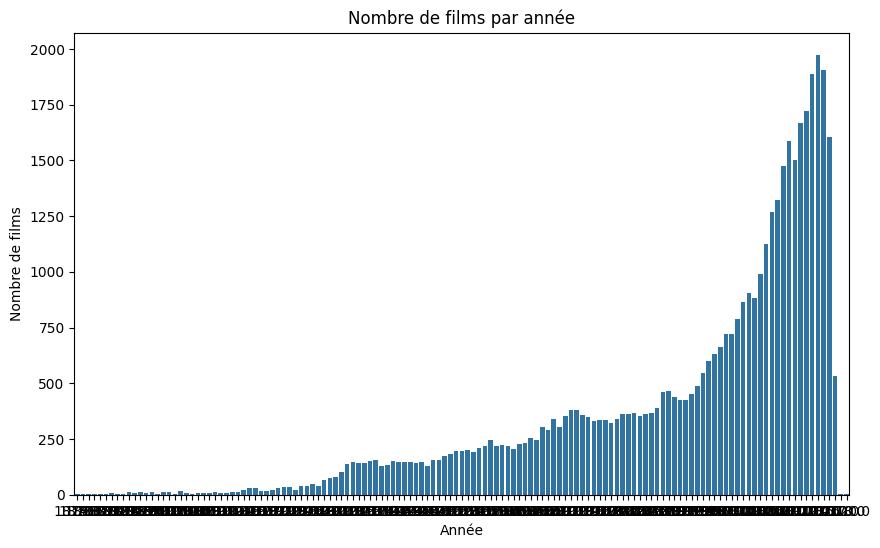

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

metadata['release_date'] = pd.to_datetime(metadata['release_date'])
metadata['year'] = metadata['release_date'].dt.year

plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x="year")
plt.title("Nombre de films par année")
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.show()

# Recommendation by popularity

Let's start with a straightforward approach to generating recommendations by suggesting the top 5 movies based on their average score. However, it's worth noting that while average score is a useful metric, it may not always provide the most personalized recommendations, as individual preferences can vary widely.

In [8]:
top_5_movies = metadata.sort_values(by="vote_average", ascending=False).head(5)
print(top_5_movies[['title', 'vote_average']])

                                                 title  vote_average
21642  Ice Age Columbus: Who Were the First Americans?          10.0
15710        If God Is Willing and da Creek Don't Rise          10.0
22396                                   Meat the Truth          10.0
22395            Marvin Hamlisch: What He Did For Love          10.0
35343                       Elaine Stritch: At Liberty          10.0


Have you seen any of these movies?  
You may have guessed that the average score is only reliable when it is averaged on a sufficient number of votes.
Use seaborn ```histplot``` method to plot the histogram of the number of votes.
For better readability you may first do this plot for the movies with less than 100 votes and then do another one for the remaining ones.

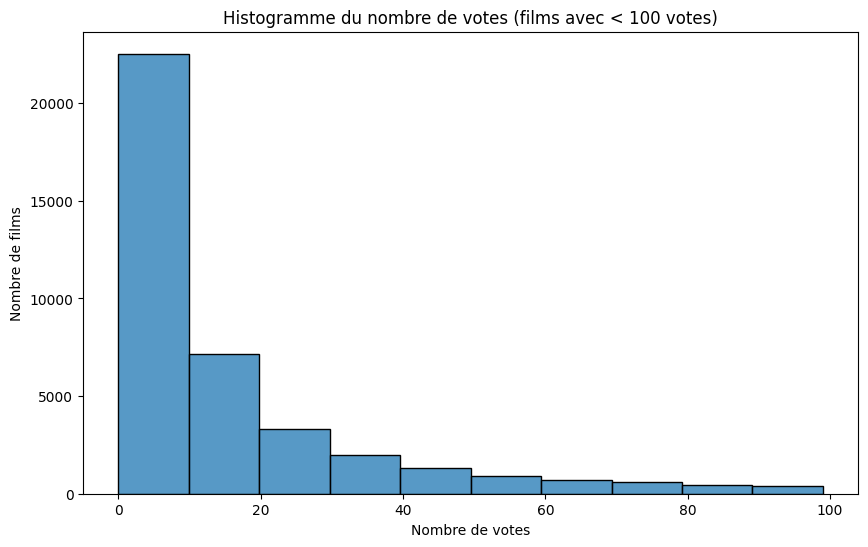

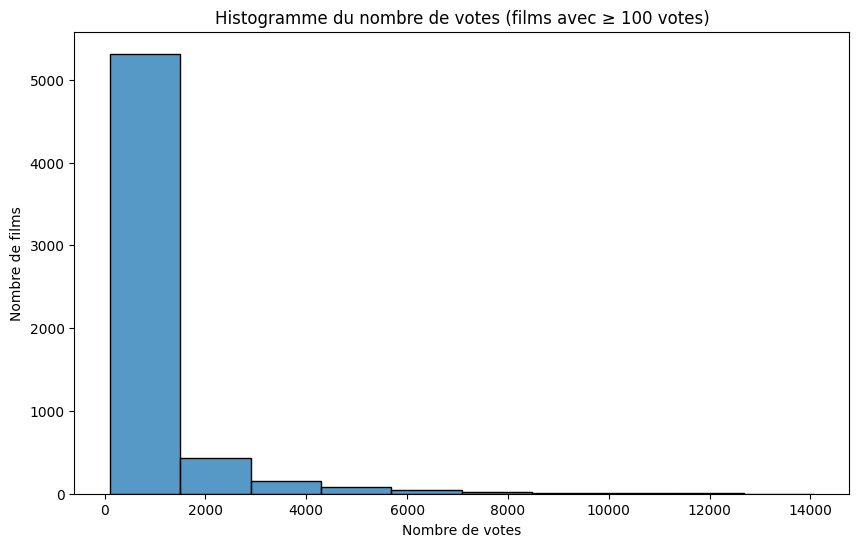

In [9]:
# Tracé de l'histogramme pour les films avec moins de 100 votes
plt.figure(figsize=(10, 6))
sns.histplot(metadata[metadata['vote_count'] < 100]['vote_count'], bins=10)
plt.title("Histogramme du nombre de votes (films avec < 100 votes)")
plt.xlabel("Nombre de votes")
plt.ylabel("Nombre de films")
plt.show()

# Tracé de l'histogramme pour les films avec 100 votes ou plus
plt.figure(figsize=(10, 6))
sns.histplot(metadata[metadata['vote_count'] >= 100]['vote_count'], bins=10)
plt.title("Histogramme du nombre de votes (films avec ≥ 100 votes)")
plt.xlabel("Nombre de votes")
plt.ylabel("Nombre de films")
plt.show()

Try to visualize the best movies according to the average vote for movies that have at least 1000 votes.  
You should now know some of these movies now.


<ipython-input-10-17eec9a59330>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies, x="vote_average", y="title", palette="viridis")


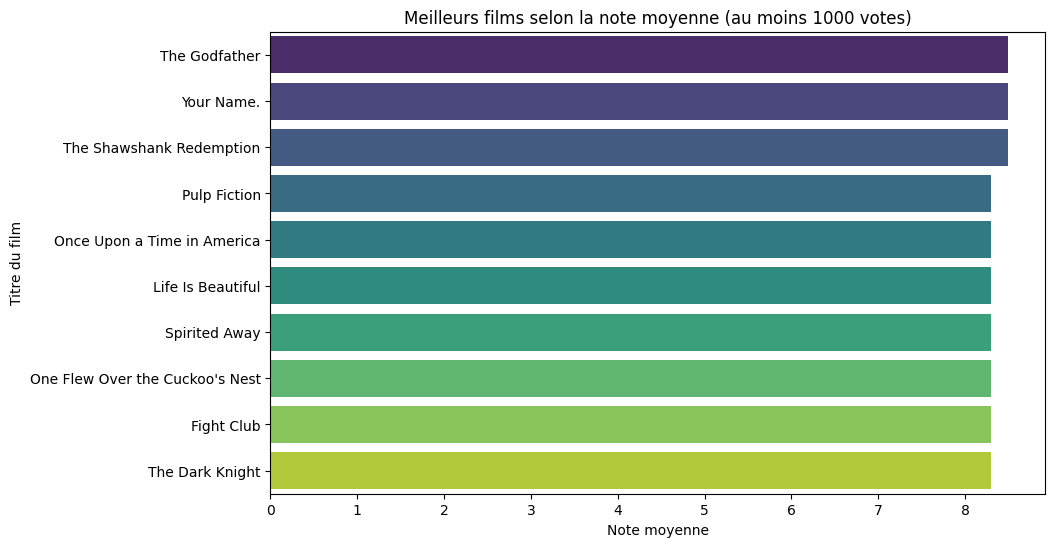

In [10]:
# Filtrage des films ayant au moins 1000 votes et tri en fonction de la note moyenne
top_movies = metadata[metadata['vote_count'] >= 1000].sort_values(by="vote_average", ascending=False).head(10)

# Tracé des meilleurs films selon la note moyenne pour ceux ayant au moins 1000 votes
plt.figure(figsize=(10, 6))
sns.barplot(data=top_movies, x="vote_average", y="title", palette="viridis")
plt.title("Meilleurs films selon la note moyenne (au moins 1000 votes)")
plt.xlabel("Note moyenne")
plt.ylabel("Titre du film")
plt.show()

## Best movies by IMDb score
IMDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online.
It might be considered as one of the most exhaustive databases on movies.
In addition, IMDb maintains a ranking of movies according to people's votes. To do so, it computes a score based on the average rating and the number of votes.
The formula they are using is described [here](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)
![](https://drive.google.com/uc?export=view&id=12J_uJ86eOimr8Y0LHTGSMmUgkBnZu9cO)  
Use this formula to compute the IMDb score for all movies and visualize the ones with the best scores. (You may use a smaller value for m, 500 for example)


<ipython-input-11-f2f9fe259382>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_imdb_movies, x="imdb_score", y="title", palette="viridis")


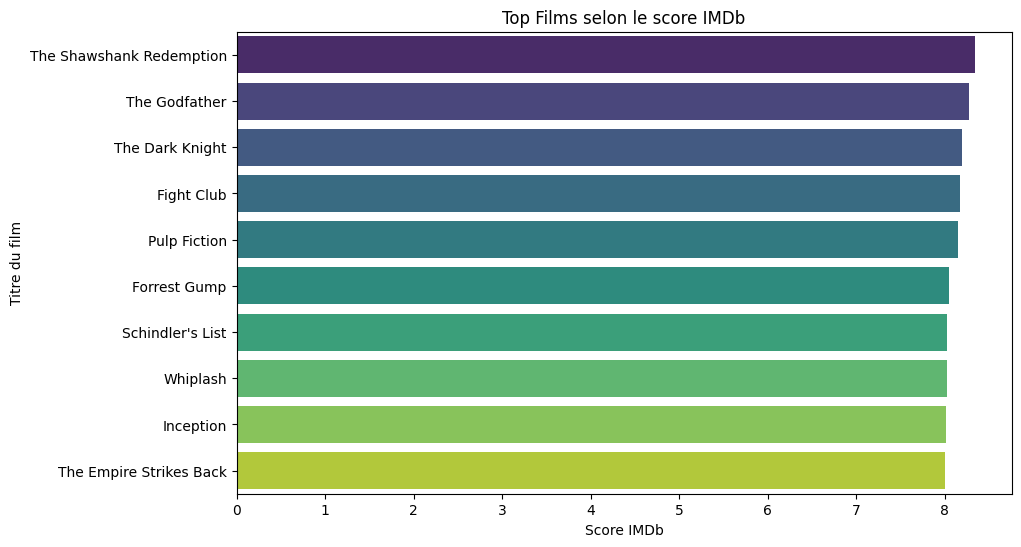

In [11]:
# Définir m et calculer C
m = 500
C = metadata.vote_average.mean()

# Définir la fonction pour calculer le score IMDb
def imdb_score(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m)) * R + (m / (v + m)) * C

# Appliquer la fonction pour obtenir le score IMDb
metadata['imdb_score'] = metadata.apply(imdb_score, axis=1)

# Visualisation des meilleurs films selon le score IMDb
top_imdb_movies = metadata.sort_values(by="imdb_score", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_imdb_movies, x="imdb_score", y="title", palette="viridis")
plt.title("Top Films selon le score IMDb")
plt.xlabel("Score IMDb")
plt.ylabel("Titre du film")
plt.show()

What were the best movies in your birth year?

<ipython-input-13-90c5003381de>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_movies_birth_year, x="vote_average", y="title", palette="viridis")


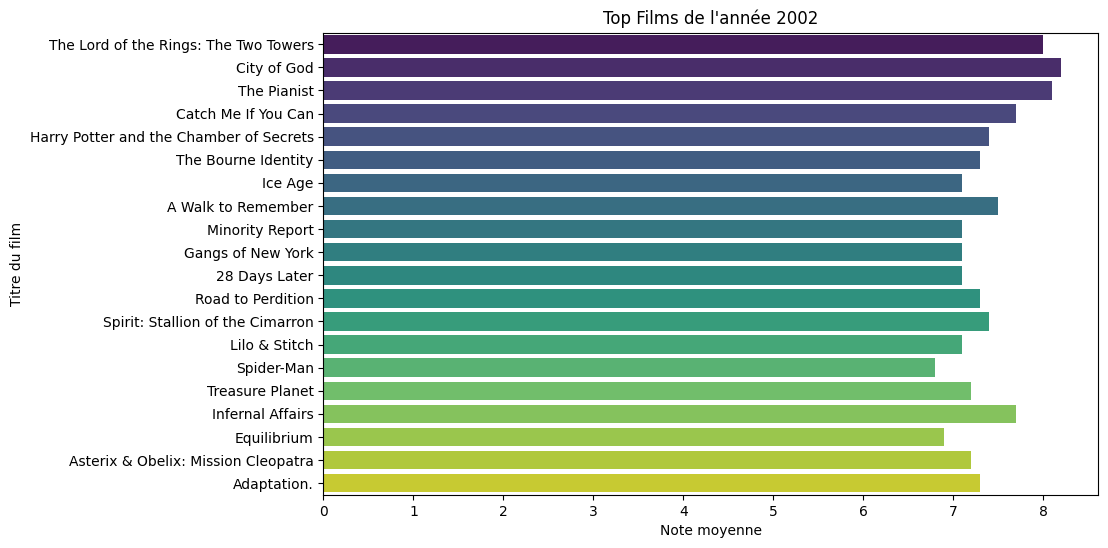

In [13]:
birth_year = 2002

# Filtrer les films de l'année de naissance et trier par vote_average
best_movies_birth_year = metadata[metadata['year'] == birth_year].sort_values(by="imdb_score", ascending=False).head(20)

# Visualiser les meilleurs films de l'année de naissance
plt.figure(figsize=(10, 6))
sns.barplot(data=best_movies_birth_year, x="vote_average", y="title", palette="viridis")
plt.title(f"Top Films de l'année {birth_year}")
plt.xlabel("Note moyenne")
plt.ylabel("Titre du film")
plt.show()

One way to refine recommendations is by considering popularity and recommending products from the same category or genre. This approach can help ensure that the suggestions are not only highly rated but also aligned with the user's interests.  
The following code will create a data frame containing one-hot encoding of the movie's genre.
Use it to recommend the best movies according to the genre and the IMDB score (for example the best Horror movies)

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(metadata['genres'].fillna('[]')),columns=mlb.classes_, index=metadata.index)
metadata = pd.concat([metadata.drop(columns=['genres']), genre_df], axis=1)
metadata.head()

,id,title,release_date,vote_average,vote_count,year,imdb_score,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,862,Toy Story,1995-10-30,7.7,5415.0,1995.0,7.524024,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,8844,Jumanji,1995-12-15,6.9,2413.0,1995.0,6.679988,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,15602,Grumpier Old Men,1995-12-22,6.5,92.0,1995.0,5.755243,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,31357,Waiting to Exhale,1995-12-22,6.1,34.0,1995.0,5.648883,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,11862,Father of the Bride Part II,1995-02-10,5.7,173.0,1995.0,5.639233,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Recommend some horror or comedy movies.

In [19]:
# Filtrer les films de genre "Comedy" ou "Horror"
filtered_metadata = metadata[(metadata["Comedy"] == 1) | (metadata["Horror"] == 1)].sort_values(by='imdb_score', ascending = False).head(10)

recommended_movies = filtered_metadata[['title','imdb_score','vote_average','Horror','Comedy', 'vote_count']]

print("Films recommandés :")
print(recommended_movies)

Films recommandés :
                          title  imdb_score  vote_average  Horror  Comedy  \
351                Forrest Gump    8.050712           8.2       0       1   
18465          The Intouchables    7.981574           8.2       0       1   
2211          Life Is Beautiful    7.976347           8.3       0       1   
1176                     Psycho    7.838418           8.3       1       0   
1225         Back to the Future    7.823283           8.0       0       1   
1213                The Shining    7.817336           8.1       1       0   
22841  The Grand Budapest Hotel    7.768488           8.0       0       1   
22131   The Wolf of Wall Street    7.743025           7.9       0       1   
30315                Inside Out    7.742352           7.9       0       1   
40882                La La Land    7.682479           7.9       0       1   

       vote_count  
351        8147.0  
18465      5410.0  
2211       3643.0  
1176       2405.0  
1225       6239.0  
1213       3

# Content based recommender systems


### Item description
An alternative approach to building a recommender system is to generate recommendations based on content characteristics. This method is particularly appealing when dealing with situations where there are limited user interactions or a scarcity of new items to recommend. It's highly probable that your catalog includes supplementary data related to the items. This additional information is typically curated manually and can contain valuable features for the development of a content-based recommender system.

In our specific case, we will obtain a dataset that includes keywords associated with the movies to facilitate this approach.

In [39]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f keywords.csv
!unzip keywords.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
keywords.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  keywords.csv.zip
replace keywords.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: keywords.csv            


In [40]:
keywords = pd.read_csv('keywords.csv')
keywords['keywords'] = keywords['keywords'].apply(lambda x: " ".join([i['name'] for i in eval(x)])).fillna('')
keywords.head()

,id,keywords
0,862,jealousy toy boy friendship friends rivalry bo...
1,8844,board game disappearance based on children's b...
2,15602,fishing best friend duringcreditsstinger old men
3,31357,based on novel interracial relationship single...
4,11862,baby midlife crisis confidence aging daughter ...


These keywords can serve as excellent descriptors for our movies.  
To enable similarity calculations between movies, it's essential to represent them in a vectorized format.  
We will now create another dataframe containing all the movies attributes.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

mlb = CountVectorizer(max_features=400)
keywords_transformed = mlb.fit_transform(keywords['keywords'])
keywords_transformed = pd.DataFrame(keywords_transformed.toarray(), columns=mlb.get_feature_names_out(), index=keywords.index)
keywords = pd.concat([keywords.drop(columns=['keywords']), keywords_transformed], axis=1)
keywords.head()

,id,1970s,3d,abuse,accident,addiction,adult,adultery,affair,africa,...,wife,witch,woman,women,world,writer,york,young,youth,zombie
0,862,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8844,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15602,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31357,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11862,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will proceed by constructing a dataframe in which each movie is depicted through its attribute vectors, encompassing keywords and genres.  
To optimize computational resources and reduce memory requirements, we will restrict our analysis to movies released after the year 2010.

In [42]:
subset = metadata[metadata['release_date'] > "2010"].reset_index(drop=True)

attributes_df = pd.merge(subset.drop(columns=['release_date', 'vote_average', 'vote_count', 'year',
       'imdb_score']), keywords, on='id')
attributes_df.head()

,id,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,wife,witch,woman,women,world,writer,york,young,youth,zombie
0,79782,Venice,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,141210,The Sleepover,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,143750,The Farmer's Wife,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,84198,A Place at the Table,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,84198,A Place at the Table,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


Now that you have a representation computed for each movie, you can calculate distances or similarities for movie pairs.  
Use scikit-learn 's [cosine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html) function, to compute the cosine similarity matrix of your dataframe.  

In [43]:
from sklearn.metrics.pairwise import cosine_distances

attributes_df = attributes_df.drop_duplicates(subset=['title'],keep='first')

# Sélectionner les colonnes représentant les genres ou caractéristiques (on exclut "id" et "title")
genre_columns = attributes_df.drop(columns=["id", "title"])

# Calcul de la matrice de similarité cosinus
cosine_sim = 1 - cosine_distances(genre_columns)

# Affichage de la matrice de similarité
print("Matrice de similarité cosinus :")
print(cosine_sim)

Matrice de similarité cosinus :
[[1.         0.         0.5        ... 0.5        0.40824829 0.        ]
 [0.         1.         0.         ... 0.5        0.         0.        ]
 [0.5        0.         1.         ... 0.5        0.40824829 0.        ]
 ...
 [0.5        0.5        0.5        ... 1.         0.40824829 0.        ]
 [0.40824829 0.         0.40824829 ... 0.40824829 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


Use the following function with your similarity matrix to recommend movies from another movie title.  
Try on several movies.

In [44]:
titles = attributes_df['title']
indices = pd.Series(attributes_df.index, index=attributes_df['title'])

def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = titles.iloc[recos]

  print(recos)

In [28]:
title = 'LEGO: The Adventures of Clutch Powers'
get_reco(title, cosine_sim)

KeyError: 'LEGO: The Adventures of Clutch Powers'

In [45]:
title = 'Iron Man 2'
get_reco(title, cosine_sim)

original: Iron Man 2
7378        Dark Summer
7379              Unity
7380    The Perfect Guy
7385       Housekeeping
7388     Badge of Honor
Name: title, dtype: object


In [46]:
title = 'How to Train Your Dragon'
get_reco(title, cosine_sim)

original: How to Train Your Dragon
7519                      Premachi Goshta
7520                          Time Please
7522    Prem Mhanje Prem Mhanje Prem Asta
7524                  Kshanbhar Vishranti
7530                           Septic Man
Name: title, dtype: object


In [47]:
title = 'Alice in Wonderland'
get_reco(title, cosine_sim)

original: Alice in Wonderland
12082                                               Goblin
12084                                             Extremis
5755      The Fantastic Flying Books of Mr Morris Lessmore
5754     Magician: The Astonishing Life and Work of Ors...
12086                                            4.1 Miles
Name: title, dtype: object


Let's free some memory in the Colab instance.

In [48]:
del(cosine_distances)
del(attributes_df)

### Images

Images are another type of content associated to products.  
It may not necessarily be relevant in the case of movies but let's do it anyway.  
We will now recommend movies according to their posters.  
First, we need to download another dataset.

In [49]:
!kaggle datasets download "ghrzarea/movielens-20m-posters-for-machine-learning"
!unzip movielens-20m-posters-for-machine-learning.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: mlp-20m/MLP-20M/81566.jpg  
  inflating: mlp-20m/MLP-20M/81568.jpg  
  inflating: mlp-20m/MLP-20M/8157.jpg  
  inflating: mlp-20m/MLP-20M/81574.jpg  
  inflating: mlp-20m/MLP-20M/8158.jpg  
  inflating: mlp-20m/MLP-20M/81583.jpg  
  inflating: mlp-20m/MLP-20M/81585.jpg  
  inflating: mlp-20m/MLP-20M/81587.jpg  
  inflating: mlp-20m/MLP-20M/81589.jpg  
  inflating: mlp-20m/MLP-20M/81591.jpg  
  inflating: mlp-20m/MLP-20M/816.jpg  
  inflating: mlp-20m/MLP-20M/81610.jpg  
  inflating: mlp-20m/MLP-20M/81613.jpg  
  inflating: mlp-20m/MLP-20M/81615.jpg  
  inflating: mlp-20m/MLP-20M/81617.jpg  
  inflating: mlp-20m/MLP-20M/81621.jpg  
  inflating: mlp-20m/MLP-20M/81629.jpg  
  inflating: mlp-20m/MLP-20M/81631.jpg  
  inflating: mlp-20m/MLP-20M/81633.jpg  
  inflating: mlp-20m/MLP-20M/81637.jpg  
  inflating: mlp-20m/MLP-20M/81639.jpg  
  inflating: mlp-20m/MLP-20M/81641.jpg  
  inflating: mlp-20m/MLP

The following code will help loading the data with Pytorch.

In [50]:
import torch
from torchvision import datasets

class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path



We will use a pre-trained network to extract the features from the posters.
Similar to what we did with the item descriptions, we will compute similarities between the movies according to these features.

The pre-trained model was trained with normalized images. Thus, we have to normalize our posters before feeding them to the network.
The following code instantiates a data loader with normalized images and provides a function to revert the normalization for visualization purposes.


In [51]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                normalize])
dataset = ImageAndPathsDataset('MLP-20M', transform)

dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

Here are some exemples of posters:

(-0.5, 1809.5, 453.5, -0.5)

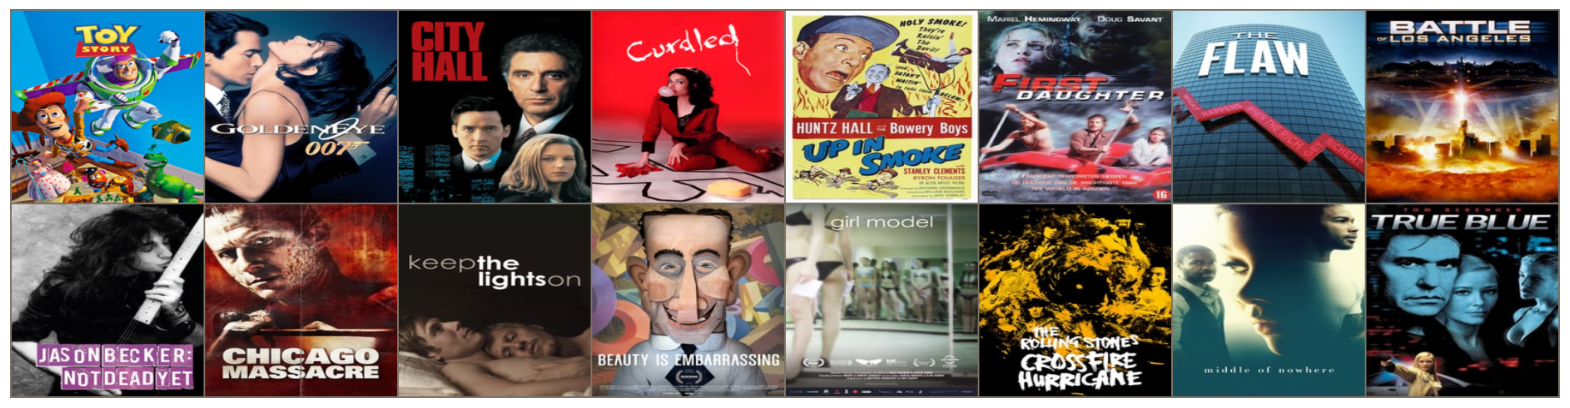

In [52]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
x, paths = next(iter(dataloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Instantiate a pre-trained a mobilenet_v3_small model (documentation [here](https://pytorch.org/vision/stable/models.html))

In [53]:
import torchvision.models as models
mobilenet = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 37.7MB/s]


Have a look to the model:

In [54]:
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

We will now crate a subset of this model to extract the features.
Use a Sequential model to get only the features followed by the avgpool layer of mobilnet and finish with a Flatten layer (```torch.nn.Flatten()```)


In [56]:
import torch.nn as nn

# Créer un sous-ensemble du modèle pour extraire les caractéristiques (features)
# Prenons toutes les couches jusqu'à la couche avgpool, puis ajoutons une couche Flatten
model = nn.Sequential(
    *list(mobilenet.children())[:-1],  # Toutes les couches sauf la dernière (classifier)
    nn.AdaptiveAvgPool2d(1),  # Moyenne de la couche AvgPool
    nn.Flatten()  # Applatir les sorties pour les rendre vectorielles
)

# Déplacer le modèle sur le GPU (si disponible)
model = model.cuda() if torch.cuda.is_available() else model

If your model is OK, it should predict 576-dimensional vectors.

In [57]:
import torch
x = torch.zeros(100, 3, 224,224).cuda()
y = model(x)
y.shape

torch.Size([100, 576])


We will proceed to establish a dataframe containing our extracted features, along with the file paths to the poster images..

In [58]:
import pandas as pd
from tqdm.notebook import tqdm

features_list = []
paths_list = []

for x, paths in tqdm(dataloader):
    with torch.no_grad():
        embeddings = model(x.cuda())
        features_list.extend(embeddings.cpu().numpy())
        paths_list.extend(paths)

df = pd.DataFrame({
    'features': features_list,
    'path': paths_list
})

df.head()

  0%|          | 0/211 [00:00<?, ?it/s]

,features,path
0,"[0.8096408, 0.2410012, 0.377241, 0.24335036, 0...",MLP-20M/MLP-20M/1.jpg
1,"[0.39853585, 1.1435974, 0.6115356, 0.30507097,...",MLP-20M/MLP-20M/10.jpg
2,"[0.30924118, -0.0037498716, -0.024863338, 0.42...",MLP-20M/MLP-20M/100.jpg
3,"[0.103911765, 0.42122528, 0.6615311, 0.0102561...",MLP-20M/MLP-20M/1000.jpg
4,"[0.38010806, -0.029013595, 0.25245783, 0.43132...",MLP-20M/MLP-20M/100003.jpg


We will now extract all the features into a numpy array that will be used to compute the similarity matrix.

In [59]:
import numpy as np
features = np.vstack(features_list)
features.shape

(26938, 576)

Now compute the cosine similarities between the embeddings of your movies.

In [60]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = 1 - cosine_distances(features)

The ```plot_image``` function  displays a poster according to it's path.  
Fill the ```plot_images``` function to plot a series of posters from a list of paths.

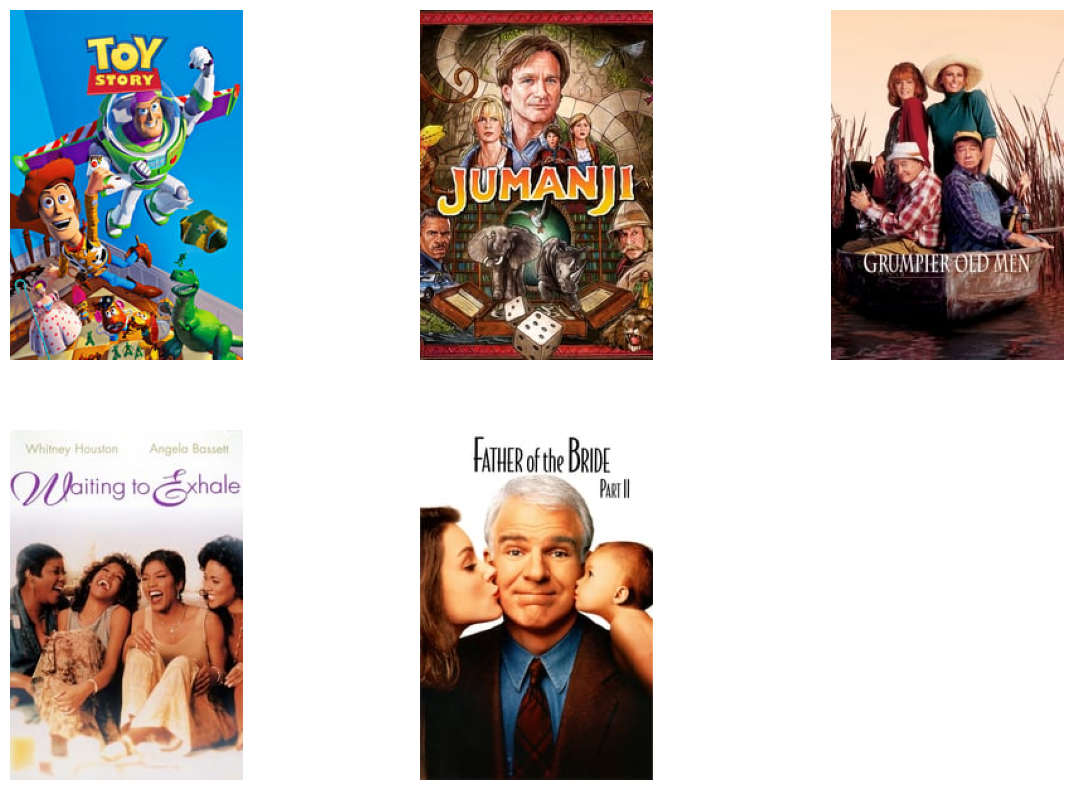

In [63]:
import matplotlib.image as mpimg

def plot_image(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')

def plot_images(paths_list):
    # Déterminer le nombre de lignes et de colonnes pour la grille
    n = len(paths_list)
    cols = 3  # Nombre de colonnes (par exemple, 3 colonnes)
    rows = (n + cols - 1) // cols  # Calcul du nombre de lignes nécessaires

    # Créer une figure avec un nombre approprié de sous-graphes
    plt.figure(figsize=(15, 5 * rows))

    for i, path in enumerate(paths_list):
        plt.subplot(rows, cols, i + 1)  # Placer l'image dans la bonne position
        plot_image(path)  # Afficher l'image

    plt.show()


plot_images(['MLP-20M/MLP-20M/1.jpg', 'MLP-20M/MLP-20M/2.jpg', 'MLP-20M/MLP-20M/3.jpg', 'MLP-20M/MLP-20M/4.jpg', 'MLP-20M/MLP-20M/5.jpg'])

Fill the following code to implement a function that plots the top 5 recommendations for a movie according to its index.

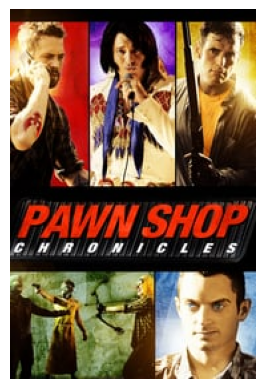

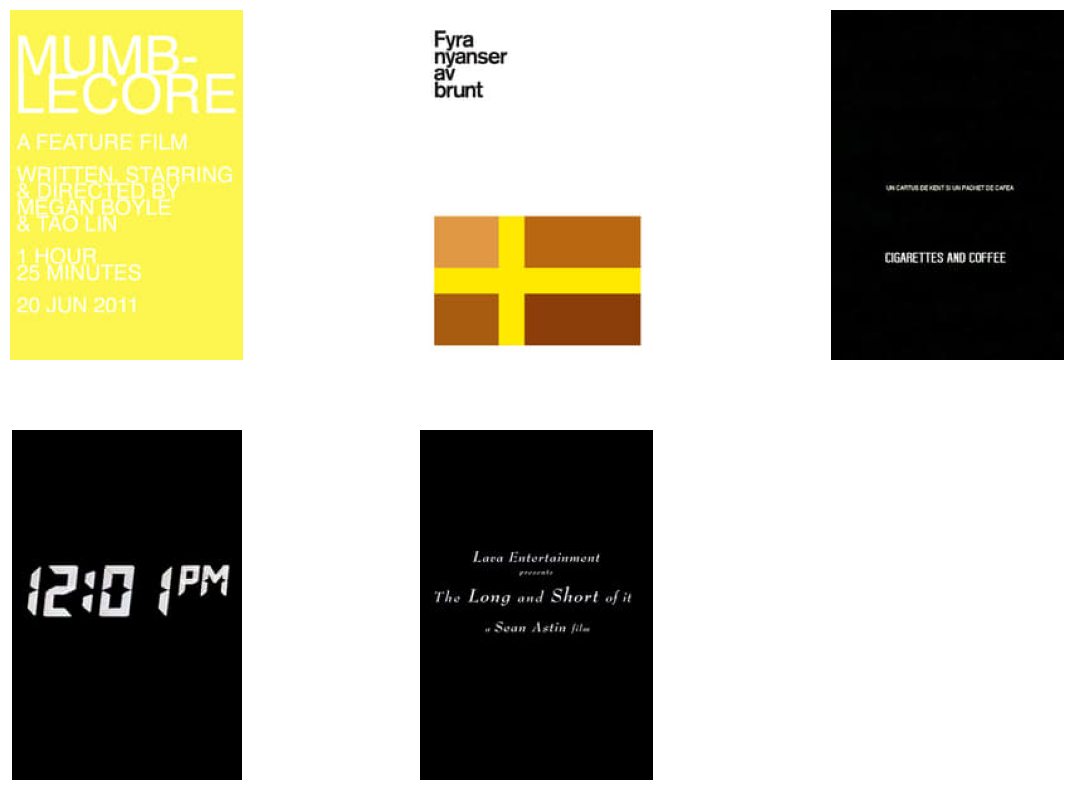

In [68]:
def plot_reco(idx, sim_matrix):
    # Afficher l'affiche du film d'origine
    plot_image(df['path'][idx])

    # Trouver les indices des 5 films les plus similaires (à l'exception du film lui-même)
    recos = sim_matrix[idx].argsort()[1:6]  # argsort() trie les valeurs, [1:6] exclut le film lui-même (indice 0)

    # Extraire les chemins des affiches des films recommandés
    reco_posters = df['path'].iloc[recos].tolist()

    # Afficher les affiches des films recommandés
    plot_images(reco_posters)

# Exemple d'utilisation avec un indice spécifique
idx = 1000  # Tu peux ajuster cet indice pour tester avec d'autres films
plot_reco(idx, cosine_sim)

Try with different movie indexes, you will be surprised by the lack of originality of the poster designers!  
Look at [this post](https://thechive.com/2020/01/20/all-movie-posters-look-the-same-what-the-hell-is-this-sht-20-photos/) to convince yourself.

## Vector databases  

Computing the similarity matrix is a very expensive operation in terms of memory and computation time that scales quadratically with the number of items.  It is also not very practical to store this matrix in a database.  
Vector databases offer a suite of advantages tailored to the needs of modern data analytics and machine learning applications. At their core, they specialize in handling high-dimensional data, allowing for efficient similarity searches—something traditional databases struggle with. This makes them invaluable for tasks like recommendation systems, image searches, and semantic text retrieval. Beyond search efficiency, vector databases are designed for scalability, capable of handling billions of vectors without a hitch. Furthermore, they often come with built-in mechanisms for distributed storage and computation, ensuring data resilience and fast query speeds even as data volumes grow. In essence, vector databases are the backbone that empowers many of the AI-driven solutions we see today.  
For our current session, we're aiming for simplicity and efficiency. Many of the standard vector databases, like [Milvus](https://milvus.io/) or [Weaviate](https://weaviate.io/), require their own dedicated installations and often need to run on separate servers or containers.  
This can introduce added complexity. Instead, we're turning to [Annoy](https://github.com/spotify/annoy) a straightforward library developped by Spotify that lets us perform efficient neighbor searches without the installation and server overhead. While Annoy is great for our present needs, do keep in mind that in larger, production scenarios, the capabilities of a dedicated vector database could be invaluable.

In [ ]:
!pip install annoy

We will thus use the annoy library to create a vector database with our features.  
In our case the database will be a simple file on the disk that we will load in memory when needed.
To create the database, we will use an AnnoyIndex with the same dimensionality as our features and a metric to compute the distance between vectors.  
Here we will use the cosine distance and set the database vector size to 576 (the size of our features).

In [ ]:
from annoy import AnnoyIndex

dim = 576
annoy_index = AnnoyIndex(dim, 'angular')

We will now fill the database with our features as indexed vectors.

In [ ]:
for i, embedding in enumerate(features_list):
    annoy_index.add_item(i, embedding)

annoy_index.build(10)

The `annoy_index.build(10)` command builds the underlying data structures required for Annoy to perform its approximate nearest neighbor searches. Specifically, the number 10 indicates that Annoy should construct 10 trees. Building multiple trees helps improve the accuracy of the search at the expense of using more memory. In essence, this command is preparing Annoy to efficiently handle future queries.

Vector databases excel at efficient similarity searches due to their foundational design principles. Traditional databases rely on exact matches or predefined indices to retrieve data. In contrast, vector databases operate in the realm of high-dimensional vector spaces. Here, data points (or vectors) that are semantically or contextually similar are often closer in distance. By leveraging algorithms optimized for these spaces, like approximate nearest neighbor (ANN) searches, vector databases quickly identify data points that lie near a query point. This spatial awareness enables them to bypass exhaustive scans and zero in on relevant results, making similarity searches both rapid and precise.
Thus querying the database for the most similar items to a given item is a very fast operation.  
Complete the following function to retrieve the most similar items to a given item.

In [ ]:
def search(query_vector, k=5):
    indices = annoy_index.get_nns_by_vector(query_vector, k)
    paths = ...
    return paths

Use this function to plot the top-k recommendations for a movie.

In [ ]:
index = 600
plot_image(df.path[index])
query_vector = df.features[index]
result = search(query_vector)
plot_images(result)

Save you database, you will need it for your project.

In [ ]:
annoy_index.save('rec_imdb.ann')

# Collaborative filtering

### Item-Item

Item-item collaborative filtering, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings.
For sake of simplicity, in this practical session, we will only focus on item-item similarity methods.
If you have time, feel free to try an user-item approach. The following [blog post](https://notebook.community/saksham/recommender-systems/Collaborative%20Filtering) may help you to do it.

We will use another dataset containing the ratings of several users on movies.

In [ ]:
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv

In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.rename(columns={'movieId':'id'})
ratings['id'] = pd.to_numeric(ratings['id'])
ratings = pd.merge(ratings, metadata[['title', 'id']], on='id')[['userId', 'id', 'rating', 'title']]
ratings.head()

In [ ]:
ratings.shape

This dataset is a bit huge and may slow down futur computations. Moreover collaborative filtering kind of suffers from products or user with few ratings.
We will only focus on the 100 movies with the most ratings and the users with the highest number of ratings.

In [ ]:
# filter movies
ratings['count'] = ratings.groupby('id').transform('count')['userId']
movieId = ratings.drop_duplicates('id').sort_values(
    'count', ascending=False).iloc[:200]['id']
ratings = ratings[ratings['id'].isin(movieId)].reset_index(drop=True)

#filter users
ratings['count'] = ratings.groupby('userId').transform('count')['id']
userId = ratings.drop_duplicates('userId').sort_values(
    'count', ascending=False).iloc[:20001]['userId']
ratings = ratings[ratings['userId'].isin(userId)].reset_index(drop=True)

ratings.shape

In [ ]:
ratings.head()

In [ ]:
ratings.title.unique()[:100]

Now, we need to build a pivot table with user in lines, movies in columns and ratings as values.  
Use pandas [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) method to create this pivot table.

In [ ]:
pivot = ...
pivot.head(100)

With this pivot table, it is now easy to compute the similarity between movies.
Indeed each movie can be represented by a vector of the users' ratings.
Instead of using a cosine similarity distance as we did earlier in the notebook, we will use the Pearson correlation score since it is already implemented in Pandas.
The pivot table has a method [```corrwith```](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html) that will return the Pairwise correlation score of one entry with all entries of the table.

In [ ]:
movie_vector = pivot["Titanic"]
similarity = pivot.corrwith(movie_vector)
...

Sort the produced results to get the best recommendations to "Titanic".
You may also try with different movies.

## Matrix factorization
Matrix factorization is certainly one of the most efficient way to build a recomender system. I really encourage you to have a look to [this article](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) presenting the matrix factorization techniques used in recommender systems.

The idea is pretty simple, it consists in factorizing the ratings matrix $R$ into the product of a user embedding matrix $U$ and an item embedding matrix $V$, such that $R \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Where
- $N$ is the number of users,
- $M$ is the number of items,
- $R_{ij}$ is the rating of the $j$th item by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing item $j$,


One these emmbeding matrices are built, predicting the rating of an user $i$ for an item $j$ consists in computing the dot product $\langle U_i, V_j \rangle$.

### Using surpise

![](https://drive.google.com/uc?export=view&id=1dh2RJ95F0j-rZyuf59G35239B42veAWD)

We will begin by using the famous Singular Value Decomposition method.
Several libraries implement this algorithm.
In this session, we will be using [Surprise](http://surpriselib.com/).
Surprise is a recommender system library implemented in Python.
It was actually developed by [Nicolas Hug](http://nicolas-hug.com/about) an INSA Toulouse Alumni!

In [ ]:
!pip install scikit-surprise

Surprise implements the SVD algorithm.  Help yourself with [the doc](https://surprise.readthedocs.io/en/stable/getting_started.html) to train an SVD model on the rating dataset.

In [ ]:
#Creating a train and a test set
testset = ratings.sample(frac=0.1, replace=False)
trainset = ratings[~ratings.index.isin(testset.index)]

assert set(testset.userId.unique()).issubset(trainset.userId.unique())
assert set(testset.id.unique()).issubset(trainset.id.unique())

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
reader = ...
data = Dataset.load_from_df(ratings[['userId', 'id', 'rating']].fillna(0), reader)
svd = ...

# Run 5-fold cross-validation and print results.
...

In [ ]:
#full dataset training
svd = SVD()
s_trainset = data.build_full_trainset()
svd.fit(s_trainset)

Let us look some ratings for one user in the test dataset.

In [ ]:
testset[testset['userId'] == 24]

What would your model predict for these exemples?

In [ ]:
uid = 24
iid = ...

svd.predict(uid, iid)

Write a code to recommend 5 movies to an user.

### Using gradient descent
Another way to compute the matrix factorization consists in using gradient descent to minimize $\text{MSE}(R, UV^\top)$ where:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

We will now implement our own matrix factorization algorith using Pytorch.  
To do so we first need to convert our ratings datasets in Pytorch datasets.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

user_list = trainset.userId.unique()
item_list = trainset.id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = user2id[self.df['userId'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating


trainloader = DataLoader(Ratings_Datset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Datset(testset), batch_size=64, num_workers=2)

These dataloader will provide mini-batches of tuples <user, movie, rating>.
We will use a special type of Pytorch layers call [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
These layers will create a mapping between an index and a vector representation.
In our case they will provide vector representations of our users and items.
We will train the matrix factorization model to minimize the prediction error between a rating and the dot product of an user embedding with a movie embedding.
![](https://drive.google.com/uc?export=view&id=1wSQbcSN_I28mF74-wnb8_qjAzRH9YDjA)

Complete the following code to implement the ```MatrixFactorization``` class in Pytorch.

In [ ]:
import torch

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_embeddings = ...
        self.item_embeddings = ...

    def forward(self, user, item):
        return torch.mul(self.user_embeddings(user), self.item_embeddings(item)).sum(1)
        #return (self.user_embeddings(user)*self.item_embeddings(item)).sum(1)

Complete the training method that we will use to train the network.

In [ ]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean


def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            r = r.unsqueeze(1)
            y_hat = ...
            loss = ...
            train_loss.append(loss.item())
            total += r.size(0)
            ...
            ...
            ...
            t.set_description(f"loss: {mean(train_loss)}")

We now have everything to train our model.
Train your model for 5 to 10 epochs.

In [ ]:
n_user = trainset.userId.nunique()
n_items = trainset.id.nunique()
model = MatrixFactorization(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

Complete the following code to evaluate your model.

In [ ]:
import math

def test(model, testloader):


    running_mae = 0
    with torch.no_grad():
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = ...
            error = ...

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5


test(model, testloader)

Try to compare the predictions of your model with actual ratings.

In [ ]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

We just trained a matrix factorization algorithm using Pytorch.
In this setting, the final prediction was made with the dot product of our embeddings.
Actually with a minimal modification of the Class, we could create a full neural network.
If we replace the dot product with a fully-connected network, we would actually have an end-to-end neural network able to predict the ratings of our users.
![](https://drive.google.com/uc?export=view&id=1THBMB-Z3db0Rn0dyYYWhN98AHcYEM-nT)  
This approach is called Neural Collaborative Filtering and is presented in this [paper](https://arxiv.org/pdf/1708.05031.pdf).
Try to fill in the following code to create an NCF network.



In [ ]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            ...
            nn.Sigmoid()
        )


    def forward(self, user, item):


        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return ...

Train your NCF network on the train dataset and test it on the test dataset.

In [ ]:
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

In [ ]:
test(model, testloader)

In [ ]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

### Implicit feedback with pytorch

In this practical session, we only worked with explicit feedbacks (ratings).
Sometimes you do not have access to such quantitative feedback and have to deal with implicit feedback.
An implicit feedback is a user's qualitative interaction with an item, such as clicking on an item (positive feedback) or stopping watching a video (negative feedback).
If you are interested in neural collaborative filtering in the case of implicit feedback, I recommend you look at this [excellent tutorial](https://sparsh-ai.github.io/rec-tutorials/matrixfactorization%20movielens%20pytorch%20scratch/2021/04/21/rec-algo-ncf-pytorch-pyy0715.html).